In [2]:
using LmaPredictdictdictedict, Flux, PyPlot

In [5]:
path_config = "/Users/alessandroconigli/Lattice/data/HVP/LMA/A654/"
path_plot="/Users/alessandroconigli/Desktop/postdoc-mainz/projects/MLtoLMA"


"/Users/alessandroconigli/Desktop/postdoc-mainz/projects/MLtoLMA"

In [7]:
fname = readdir(path_config)
idx_cut = findall(x->x<=2500 , parse.(Int64, fname))
fname = fname[idx_cut]
idx = sortperm( parse.(Int64, fname))
fname = fname[idx]

cnfgarr = Vector{LMAConfig}(undef, 0)
for f in fname
    push!(cnfgarr, get_LMAConfig(joinpath(path_config, f), "g5-g5", em="PA", bc=false))
end

In [8]:
# Select a specific Tsource and divide data into training and test set for rr re and ee components
TSRC="12"
NCNFG = length(cnfgarr)
TVALS = length(cnfgarr[1].data["rr"][TSRC]) -1

rr_data = Array{Float64}(undef, 2000, TVALS)
ee_data = Array{Float64}(undef, 2000, TVALS)
re_data = Array{Float64}(undef, 2000, TVALS)

rr_data_test = Array{Float64}(undef, 500, TVALS)
ee_data_test = Array{Float64}(undef, 500, TVALS)
re_data_test = Array{Float64}(undef, 500, TVALS)


for (k, dd) in enumerate(getfield.(cnfgarr, :data)[1:2000])
    rr_data[k,:] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    ee_data[k,:] = getindex(getindex(dd, "ee"), TSRC)[2:end]
    re_data[k,:] = getindex(getindex(dd, "re"), TSRC)[2:end]
end
for (k, dd) in enumerate(getfield.(cnfgarr, :data)[2001:2500])
    rr_data_test[k,:] = getindex(getindex(dd, "rr"), TSRC)[2:end]
    ee_data_test[k,:] = getindex(getindex(dd, "ee"), TSRC)[2:end]
    re_data_test[k,:] = getindex(getindex(dd, "re"), TSRC)[2:end]
end

rest-rest vs rest-eigen contribution


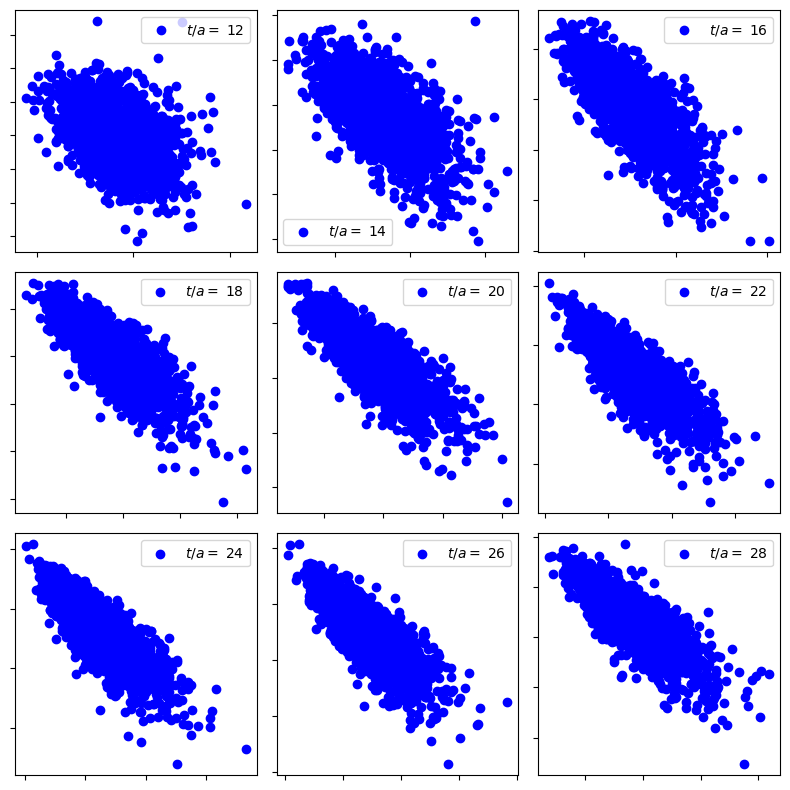

In [9]:
## DATA INSPECTION - RR vs RE
println("rest-rest vs rest-eigen contribution")
fig = figure(figsize=(8,8))
for k in 1:9
    ii = 330 + k
    tt = 10 + 2*k
    # println(ii)
    subplot(ii)
    scatter(rr_data[:,tt], re_data[:,tt], color="blue", label=L"$t/a=$"*" $(tt)")
    # scatter(ee_data[:,tt], re_data[:,tt], color="orange", label=L"$t/a=$"*" $(tt)" )
    ax=gca()
    setp(ax.get_xticklabels(),visible=false) # Disable x tick labels
    setp(ax.get_yticklabels(),visible=false) # Disable y tick labels
    legend()
end

PyPlot.tight_layout()
display(gcf())
#savefig(joinpath(path_plot, "rr_vs_re.pdf"))
close("all")

eigen-eigen vs rest-eigen contribution


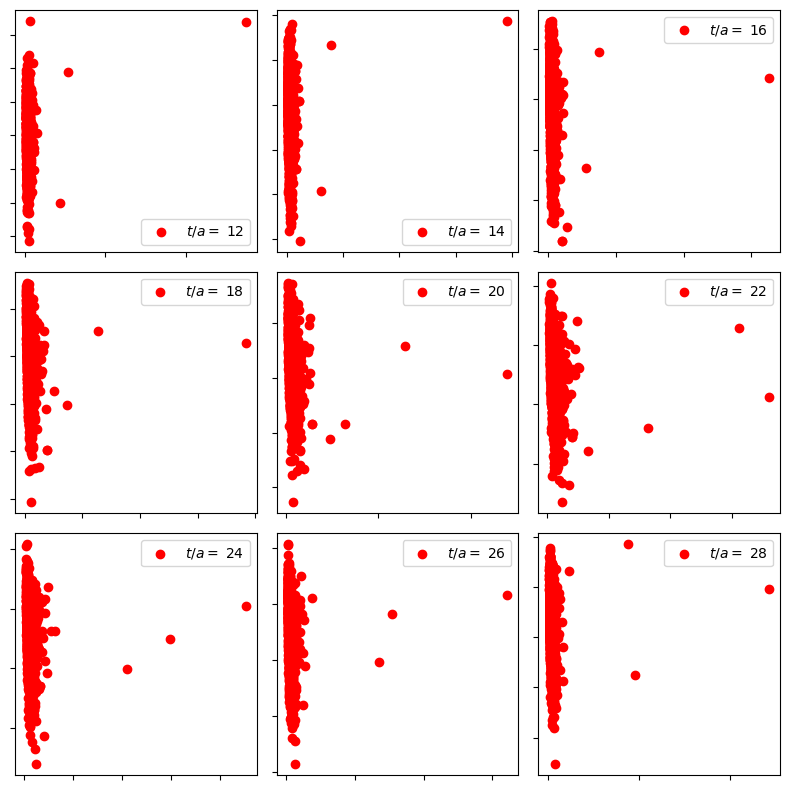

In [11]:
## DATA INSPECTION - EE vs RE
println("eigen-eigen vs rest-eigen contribution")
fig = figure(figsize=(8,8))
for k in 1:9
    ii = 330 + k
    tt = 10 + 2*k
    # println(ii)
    subplot(ii)
    scatter(ee_data[:,tt], re_data[:,tt], color="red", label=L"$t/a=$"*" $(tt)" )
    ax=gca()
    setp(ax.get_xticklabels(),visible=false) # Disable x tick labels
    setp(ax.get_yticklabels(),visible=false) # Disable y tick labels
    #xlim(-0.02, 0.05)
    legend()
end

PyPlot.tight_layout()
display(gcf())
#savefig(joinpath(path_plot, "ee_vs_re.pdf"))
close("all")

rest-rest vs eigen-eigen contribution


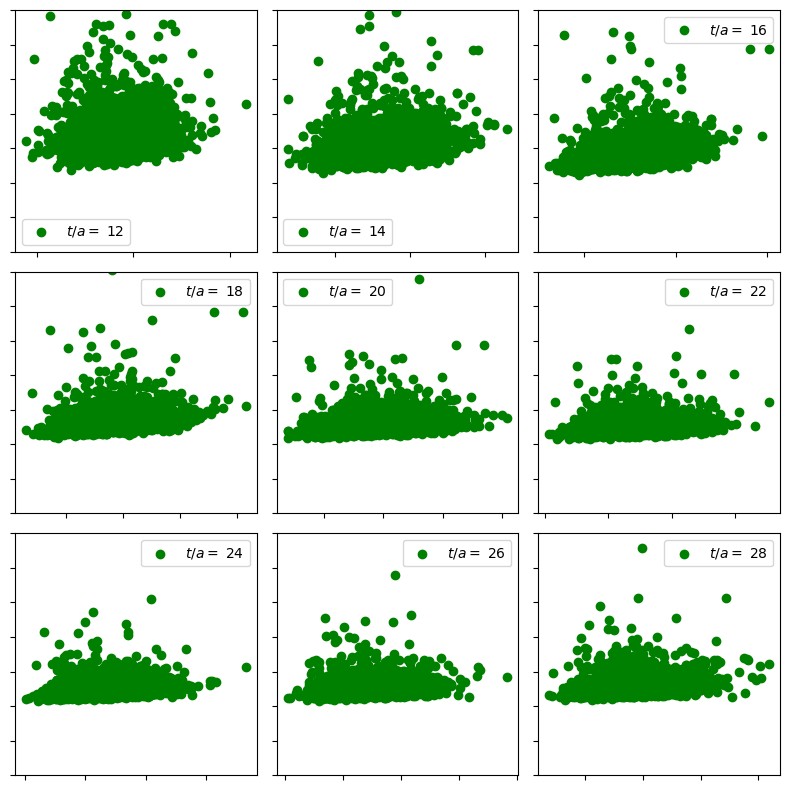

In [15]:
## DATA INSPECTION - RR vs EE
println("rest-rest vs eigen-eigen contribution")
fig = figure(figsize=(8,8))
for k in 1:9
    ii = 330 + k
    tt = 10 + 2*k
    # println(ii)
    subplot(ii)
    scatter(rr_data[:,tt], ee_data[:,tt], color="green", label=L"$t/a=$"*" $(tt)" )
    ax=gca()
    setp(ax.get_xticklabels(),visible=false) # Disable x tick labels
    setp(ax.get_yticklabels(),visible=false) # Disable y tick labels
    ylim(-0.02,0.05)

    legend()
end
PyPlot.tight_layout()
display(gcf())
savefig(joinpath(path_plot, "ee_vs_re.pdf"))
close("all")

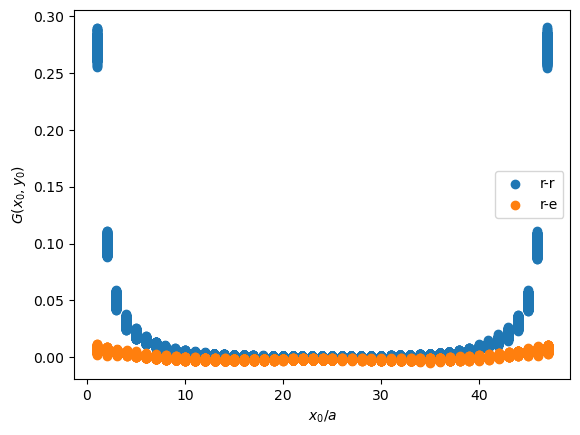

In [16]:
## EXPLORE
xx =hcat(fill(collect(1:size(rr_data,2)), size(rr_data,1))...)
scatter(xx, transpose(rr_data), label="r-r")
scatter(xx .+ 0.05, transpose(re_data), label="r-e")
# scatter(xx .+ 0.1, transpose(ee_data), label="e-e")
# scatter(xx, tot, label="tot")
# ylim(-0.02, 0.02)
# xlim(10, 40)
xlabel(L"$x_0/a$")
ylabel(L"$G(x_0,y_0)$")
legend()
display(gcf())
PyPlot.close("all")

## First reasonable attempt 
Linear regression for rest-eigen prediction from rest-rest contributions  
    - All contributions from a single source position `TSRC`  
    - 2000 cnfgs as training set, 500 cnfgs as test set  
    - Individual model for each time slice   



In [32]:
models = []

for t in 1:TVALS
    push!(models, Dense(1=>1))
end

function loss(y, ypred)
    lss = Flux.mse(ypred, y)
    return lss
end

#function train(net, eta, x, y)
#    opt = Flux.setup(Adam(eta), net)
#    grads = Flux.gradient(m -> Flux.mse(m(x), y), net)
#    Flux.update!(opt, net, grads[1])
#end

function train(net, eta, x, y)
    opt = Flux.setup(Adam(eta), net)
    
    lss, grads = Flux.withgradient(net) do net
        loss(y, net(x))
    end
    Flux.update!(opt, net, grads[1])
    return lss
end

train (generic function with 1 method)

 13.280489 seconds (383.35 M allocations: 22.131 GiB, 13.64% gc time, 0.96% compilation time)


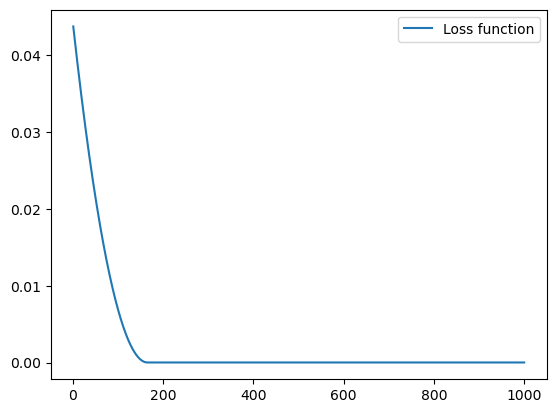

In [33]:
# TRAINING
EPOCHS = 1000
ETA = 0.001

lss = []
@time begin 
    for t in 1:TVALS
        for ep in 1:EPOCHS
            train(models[t], ETA, hcat(rr_data[:,t]...), hcat(re_data[:,t]...))
            ll = loss(hcat(re_data[:,t]...), models[t](hcat(rr_data[:,t]...)))
            if t == 1
                push!(lss, ll)
            end
        end
    end
end
plot(collect(1:length(lss)), lss, label="Loss function")
legend()
display(gcf())
close("all")

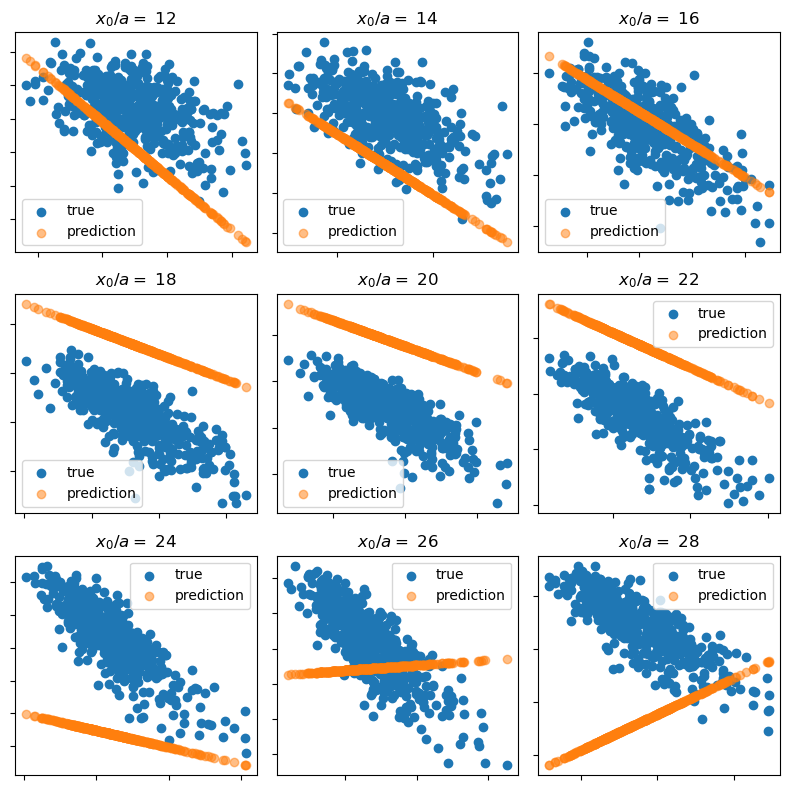

In [34]:
fig = figure(figsize=(8,8))

for k in 1:9
    TT = 10+2*k
    ii = 330 + k
    ypred = models[TT](hcat(rr_data_test[:,TT]  ...))
    ytrue = hcat(re_data_test[:,TT]...)

    subplot(ii)
    ax=gca()
    scatter(rr_data_test[:,TT] , vcat(ytrue...), label="true")
    scatter(rr_data_test[:,TT] , vcat(ypred...), label="prediction", alpha=0.5)
    setp(ax.get_xticklabels(),visible=false) # Disable x tick labels
    setp(ax.get_yticklabels(),visible=false) # Disable y tick label
    title(L"$x_0/a=$"* " $(TT)")
   legend() 
end
PyPlot.tight_layout()
display(gcf())
savefig(joinpath(path_plot, "predict_rr_vs_re.pdf"))
# savefig(joinpath(path_plot, "ee_vs_re.pdf"))
close("all")
